# Exercise 1: Exploratory Analysis over the `time-travel` dataset

Load the `travel-times-na.csv` data

**Answer the following questions:**

1. PART 1: Perform a complete data quality assessment
   1. Are there duplicated entries in this dataset? If any, remove them.
   1. Check and correct data types in case they are not correct
   1. Are there missing values in this dataset? Get the distribution of missing values per column (the proportion of missing values).
   1. If any, fill the missing values following this instructions:
      - If the proportion of missing values is greater than 80%, remove the column.
      - If not:
         - For numeric columns, use the mean value of the column
         - For string columns, use the most repeated value (the mode)
---         
         
2. PART 2: Using the resulting dataset from the previous data quality process, answer the following questions
   1. In what date the trip started earlier?
   1. What trip was the fastest (in terms of TotalTime)?
   1. When was the longest trip to home?
   1. What's the mean of the `AvgMovingSpeed` per `DayOfWeek`?
   1. Create a new column called `NotMovingTime` with the time the car was not moving. Get the mean of `NotMovingTime` per hour of day. _(Challenge: To get the hour of the day you will need to extract the two first digits of `StartTime`. Find on the internet how to do this directly with pandas in just one operation)_
   1. How many different days (in the trip to GSK) the 407 highway was taken? Does this days this guy saved time (in average) compared to the days the toll highway was not taken?

---
   
3. PART 3 (BONUS): Now, we are trying to implement a more sophisticated imputation method for missing values in `AvgSpeed`, `AvgMovingSpeed`, `TotalTime` and `MovingTime`.
   - Create a now column named `DayZone` with values `EarlyMorning` or `LateMorning`, `EarlyEvening` and `LateEvening` depending on the `StartTime`:
      - `EarlyMorning` - Before 8:00
      - `LateMorning` - After 8:00 (included) and Before 12:00
      - `EarlyEvening` - Before 17:00 and After 12:00
      - `LateEvening` - After 17:00 (included)
   - Fill the missing values with the corresponding mean value given the `DayZone` and `DayOfWeek`, that is, if there is a missing value for a Friday in the early morning, fill it just with the mean speed calculated from all Fridays in the early morning.
      - Hint: First calculate the average of the columns by `DayZone` and `DayOfWeek`. Then, use this auxiliary table to fill missing values (`pd.combine_first`)
      

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("data/travel-times-na.csv")

In [3]:
df.head()

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Comments
0,1/6/2012,16:37,Friday,Home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN
1,1/6/2012,08:20,Friday,GSK,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN
2,1/4/2012,16:17,Wednesday,Home,51.27,127.4,82.0,85.8,NaN,37.5,35.9,No,NaN
3,1/4/2012,07:53,Wednesday,GSK,49.17,132.3,74.2,82.9,NaN,39.8,35.6,No,NaN
4,1/3/2012,18:57,Tuesday,Home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,No,NaN


## 1. PART 1

At this point, let's get a profile report with Pandas Profiling to figure out what's the state of data

#### A. Are there duplicated entries in this dataset? If any, remove them.

In [4]:
df.duplicated().any()

False

There are no duplicated entries

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            205 non-null    object 
 1   StartTime       205 non-null    object 
 2   DayOfWeek       205 non-null    object 
 3   GoingTo         205 non-null    object 
 4   Distance        205 non-null    float64
 5   MaxSpeed        187 non-null    float64
 6   AvgSpeed        187 non-null    float64
 7   AvgMovingSpeed  205 non-null    float64
 8   FuelEconomy     186 non-null    float64
 9   TotalTime       187 non-null    float64
 10  MovingTime      187 non-null    float64
 11  Take407All      205 non-null    object 
 12  Comments        24 non-null     object 
dtypes: float64(7), object(6)
memory usage: 20.9+ KB


#### B. Check and correct data types in case they are not correct

In [6]:
df["Datetime"] = df.Date + " " + df.StartTime

In [7]:
df.Datetime = pd.to_datetime(df.Datetime)

In [8]:
df.Date = pd.to_datetime(df.Date)

#### B. Are there missing values in this dataset? Get the distribution of missing values per column (the proportion of missing values).

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            205 non-null    datetime64[ns]
 1   StartTime       205 non-null    object        
 2   DayOfWeek       205 non-null    object        
 3   GoingTo         205 non-null    object        
 4   Distance        205 non-null    float64       
 5   MaxSpeed        187 non-null    float64       
 6   AvgSpeed        187 non-null    float64       
 7   AvgMovingSpeed  205 non-null    float64       
 8   FuelEconomy     186 non-null    float64       
 9   TotalTime       187 non-null    float64       
 10  MovingTime      187 non-null    float64       
 11  Take407All      205 non-null    object        
 12  Comments        24 non-null     object        
 13  Datetime        205 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(5)
memory usage: 

In [10]:
null_pct = df.isnull().sum() / len(df) * 100
null_pct.sort_values(ascending=False)

Comments          88.292683
FuelEconomy        9.268293
MaxSpeed           8.780488
AvgSpeed           8.780488
TotalTime          8.780488
MovingTime         8.780488
Date               0.000000
StartTime          0.000000
DayOfWeek          0.000000
GoingTo            0.000000
Distance           0.000000
AvgMovingSpeed     0.000000
Take407All         0.000000
Datetime           0.000000
dtype: float64

<Axes: title={'center': '% of Missing Values'}>

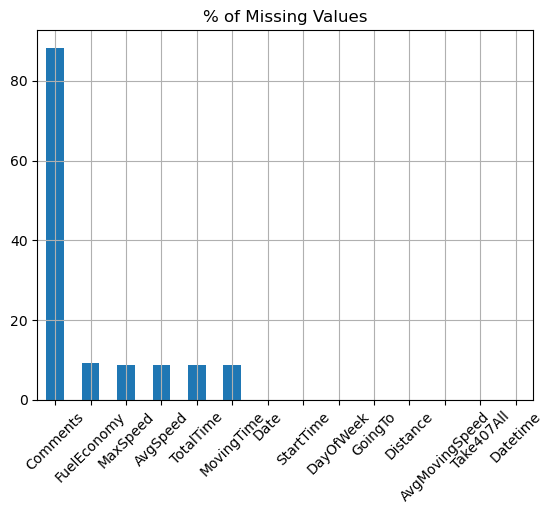

In [11]:
# represent the results in a plot
null_pct.sort_values(ascending=False).plot(kind="bar", rot=45, title="% of Missing Values", grid=True)

#### C. If any, fill the missing values following this instructions:
- If the proportion of missing values is greater than 80%, remove the column.
- If not:
   - For numeric columns, use the mean value of the column
   - For string columns, use the most repeated value (the mode)

Only the `Comments` column have more than 80% of missing values. Let's drop the column

In [12]:
df = df.drop(columns=["Comments"])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            205 non-null    datetime64[ns]
 1   StartTime       205 non-null    object        
 2   DayOfWeek       205 non-null    object        
 3   GoingTo         205 non-null    object        
 4   Distance        205 non-null    float64       
 5   MaxSpeed        187 non-null    float64       
 6   AvgSpeed        187 non-null    float64       
 7   AvgMovingSpeed  205 non-null    float64       
 8   FuelEconomy     186 non-null    float64       
 9   TotalTime       187 non-null    float64       
 10  MovingTime      187 non-null    float64       
 11  Take407All      205 non-null    object        
 12  Datetime        205 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(4)
memory usage: 20.9+ KB


The rest of the columns with missing values (< 80%) are `MaxSpeed`, `AvgSpeed`, `TotalTime`, `MovingTime` and `FuelEconomy`. All of them are numeric, son let's fill with the mean.

In [14]:
df = df.fillna({
    "MaxSpeed": df.MaxSpeed.mean(),
    "AvgSpeed": df.AvgSpeed.mean(),
    "TotalTime": df.TotalTime.mean(),
    "MovingTime": df.MovingTime.mean(),
    "FuelEconomy": df.FuelEconomy.mean()
})

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            205 non-null    datetime64[ns]
 1   StartTime       205 non-null    object        
 2   DayOfWeek       205 non-null    object        
 3   GoingTo         205 non-null    object        
 4   Distance        205 non-null    float64       
 5   MaxSpeed        205 non-null    float64       
 6   AvgSpeed        205 non-null    float64       
 7   AvgMovingSpeed  205 non-null    float64       
 8   FuelEconomy     205 non-null    float64       
 9   TotalTime       205 non-null    float64       
 10  MovingTime      205 non-null    float64       
 11  Take407All      205 non-null    object        
 12  Datetime        205 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(7), object(4)
memory usage: 20.9+ KB


In [16]:
df.to_csv("processed/travel-times-na-processed.csv", index=False)

## 2. PART 2

### A. On what date the trip started earlier?

In [144]:
# we can apply the min function to a string (ordered alphabetically, so it works with numbers also)
df[df.StartTime == df.StartTime.min()]

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Datetime
13,2011-12-20,06:04,Tuesday,GSK,49.01,119.0,77.4,82.0,8.89,38.0,35.9,No,2011-12-20 06:04:00


In [145]:
# other way, just to get the Date
df.loc[df.StartTime == df.StartTime.min(), "Date"]

13   2011-12-20
Name: Date, dtype: datetime64[ns]

It was on 12/20/2011

### B. What trip was the fastest (in terms of TotalTime)?

In [146]:
# the same as before
df[df.TotalTime == df.TotalTime.max()]

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Datetime
49,2011-11-21,07:24,Monday,GSK,52.25,127.3,38.1,50.3,10.05,82.3,62.4,No,2011-11-21 07:24:00


### C. When was the longest trip to home?

In [147]:
df[(df.Distance == df.Distance.max()) & (df.GoingTo == "Home")]

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Datetime
44,2011-11-23,16:17,Wednesday,Home,60.32,129.4,68.9,74.6,9.3,52.5,48.5,No,2011-11-23 16:17:00


In [148]:
# other way. sorting the dataframe
df[df.GoingTo == "Home"].sort_values("Distance", ascending=False).head(1)

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Datetime
44,2011-11-23,16:17,Wednesday,Home,60.32,129.4,68.9,74.6,9.3,52.5,48.5,No,2011-11-23 16:17:00


### D. What's the mean of the AvgMovingSpeed per DayOfWeek? What's the best day for driving?

In [149]:
df.groupby("DayOfWeek")["AvgMovingSpeed"].mean()

DayOfWeek
Friday       87.937037
Monday       81.405128
Thursday     82.809091
Tuesday      80.893750
Wednesday    79.348936
Name: AvgMovingSpeed, dtype: float64

The best day is Friday. We can drive faster

### E. Create a new column called `NotMovingTime` with the time the car was not moving. Get the mean of `NotMovingTime` per hour of day.

In [150]:
# create two new columns
df["NotMovingTime"] = df["TotalTime"] - df["MovingTime"]
df["Hour"] = df.Datetime.dt.hour

In [151]:
df.groupby("Hour")["NotMovingTime"].mean()

Hour
6     3.751337
7     4.236510
8     4.188321
9     1.000000
12    2.690802
15    4.400000
16    3.934970
17    4.145381
18    2.300000
20    0.600000
Name: NotMovingTime, dtype: float64

The hours with more traffic (assuming this is the cause of staying stopped) are 7 and 17

### F. How many different days (in the trip to GSK) the 407 highway was taken? Does this days this guy saved time (in average) compared to the days the toll highway was not taken?

In [152]:
# First I check that there is only one trip per day to GSK
df[df.GoingTo == "GSK"]["Date"].value_counts().max()

1

In [153]:
df[df.GoingTo == "GSK"].groupby("Take407All").size()

Take407All
No     80
Yes    25
dtype: int64

The 407 was taken 25 days

In [154]:
# let's calculate the average time conditioned to taking the 407 or not
res = df[df.GoingTo == "GSK"].groupby("Take407All")["TotalTime"].mean()
res

Take407All
No     44.066183
Yes    34.639872
Name: TotalTime, dtype: float64

In [155]:
print(f"Going to GSK through the 407 is {round(1-res.loc['Yes']/res.loc['No'], 2)*100}% faster")

Going to GSK through the 407 is 21.0% faster


## PART 3

### A. Create a new column named `DayZone` with values `EarlyMorning` or `LateMorning`, `EarlyEvening` and `LateEvening` depending on the `StartTime`

In [2]:
import pandas as pd

In [5]:
df = pd.read_csv("data/travel-times-na.csv")
df["Datetime"] = df.Date + "T" + df.StartTime
df.Datetime = pd.to_datetime(df.Datetime, format="%m/%d/%YT%H:%M")

In [6]:
df.head()

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Comments,Datetime
0,1/6/2012,16:37,Friday,Home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN,2012-01-06 16:37:00
1,1/6/2012,08:20,Friday,GSK,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN,2012-01-06 08:20:00
2,1/4/2012,16:17,Wednesday,Home,51.27,127.4,82.0,85.8,NaN,37.5,35.9,No,NaN,2012-01-04 16:17:00
3,1/4/2012,07:53,Wednesday,GSK,49.17,132.3,74.2,82.9,NaN,39.8,35.6,No,NaN,2012-01-04 07:53:00
4,1/3/2012,18:57,Tuesday,Home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,No,NaN,2012-01-03 18:57:00


In [157]:
df["Hour"] = df.Datetime.dt.hour

In [158]:
# classic python way: build a new list with the values iterating over the StartTime series
def get_dayzone(series):
    dayzone = []
    for element in series:
        hour = int(element[:2])
        if hour<8:
            dayzone.append("EarlyMorning")
        elif (hour>=8) and (hour<12):
            dayzone.append("LateMorning")
        elif (hour>12) and (hour<17):
            dayzone.append("EarlyEvening")
        else:
            dayzone.append("LateEvening")
            
    return dayzone

df["DayZone"] = get_dayzone(df["StartTime"])

In [159]:
# pandas way. using the apply function. the apply function will apply the provided function to each row
def apply_dayzone(hour):
    if hour<8:
        return "EarlyMorning"
    elif (hour>=8) and (hour<12):
        return "LateMorning"
    elif (hour>12) and (hour<17):
        return "EarlyEvening"
    else:
        return "LateEvening"
    
df["DayZone"] = df["Hour"].apply(apply_dayzone)

In [160]:
df.head()

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Comments,Datetime,Hour,DayZone
0,1/6/2012,16:37,Friday,Home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN,2012-01-06 16:37:00,16,EarlyEvening
1,1/6/2012,08:20,Friday,GSK,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN,2012-01-06 08:20:00,8,LateMorning
2,1/4/2012,16:17,Wednesday,Home,51.27,127.4,82.0,85.8,NaN,37.5,35.9,No,NaN,2012-01-04 16:17:00,16,EarlyEvening
3,1/4/2012,07:53,Wednesday,GSK,49.17,132.3,74.2,82.9,NaN,39.8,35.6,No,NaN,2012-01-04 07:53:00,7,EarlyMorning
4,1/3/2012,18:57,Tuesday,Home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,No,NaN,2012-01-03 18:57:00,18,LateEvening


### B. Fill the missing values with the corresponding mean value given the DayZone and DayOfWeek

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            205 non-null    object        
 1   StartTime       205 non-null    object        
 2   DayOfWeek       205 non-null    object        
 3   GoingTo         205 non-null    object        
 4   Distance        205 non-null    float64       
 5   MaxSpeed        187 non-null    float64       
 6   AvgSpeed        187 non-null    float64       
 7   AvgMovingSpeed  205 non-null    float64       
 8   FuelEconomy     186 non-null    float64       
 9   TotalTime       187 non-null    float64       
 10  MovingTime      187 non-null    float64       
 11  Take407All      205 non-null    object        
 12  Comments        24 non-null     object        
 13  Datetime        205 non-null    datetime64[ns]
 14  Hour            205 non-null    int64         
 15  DayZon

In [162]:
meanvals = df.groupby(["DayZone","DayOfWeek"])[["MaxSpeed","AvgSpeed","TotalTime","MovingTime"]].mean()
meanvals

MaxSpeed   AvgSpeed  TotalTime  MovingTime
DayZone      DayOfWeek                                              
EarlyEvening Friday     128.800000  78.400000  39.166667   36.366667
             Monday     125.609091  71.245455  44.090909   38.545455
             Thursday   129.583333  73.866667  41.733333   37.716667
             Tuesday    128.175000  79.400000  39.600000   36.775000
             Wednesday  126.255556  73.666667  42.833333   40.011111
EarlyMorning Friday     127.560000  75.200000  40.080000   36.460000
             Monday     127.027273  68.081818  46.709091   41.109091
             Thursday   127.877778  74.588889  41.877778   38.166667
             Tuesday    126.838462  74.053846  42.484615   38.892308
             Wednesday  127.066667  72.366667  43.083333   38.808333
LateEvening  Friday     128.512500  83.287500  37.900000   34.962500
             Monday     128.328571  80.057143  38.728571   35.957143
             Thursday   127.758333  72.416667  42.508333   38.850000
             Tuesday    129.278947  72.589474  43.673684   38.810526
             Wednesday  127.190909  70.490909  44.318182   40.372727
LateMorning  Friday     127.200000  85.133333  36.266667   33.888889
             Monday     128.433333  72.883333  43.600000   36.733333
             Thursday   127.381818  77.981818  40.409091   35.981818
             Tuesday    128.977778  74.500000  41.033333   37.244444
             Wednesday  126.666667  74.633333  41.091667   37.025000

In [163]:
# now we need to set DayZone and DayOfWeek as index in the original DataFrame in order to apply de "combine_first" function
dfi = df.set_index(["DayZone","DayOfWeek"])
dfi.head()

,,Date,StartTime,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Comments,Datetime,Hour
DayZone,DayOfWeek,,,,,,,,,,,,,,
EarlyEvening,Friday,1/6/2012,16:37,Home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN,2012-01-06 16:37:00,16
LateMorning,Friday,1/6/2012,08:20,GSK,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN,2012-01-06 08:20:00,8
EarlyEvening,Wednesday,1/4/2012,16:17,Home,51.27,127.4,82.0,85.8,NaN,37.5,35.9,No,NaN,2012-01-04 16:17:00,16
EarlyMorning,Wednesday,1/4/2012,07:53,GSK,49.17,132.3,74.2,82.9,NaN,39.8,35.6,No,NaN,2012-01-04 07:53:00,7
LateEvening,Tuesday,1/3/2012,18:57,Home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,No,NaN,2012-01-03 18:57:00,18


In [164]:
# apply the combine_first function. this will fill the null values given the "meanvals" dataframe
df = dfi.combine_first(meanvals)

In [165]:
# restore the indexes in the original dataframe
df = df.reset_index()

In [166]:
df.head()

,DayZone,DayOfWeek,AvgMovingSpeed,AvgSpeed,Comments,Date,Datetime,Distance,FuelEconomy,GoingTo,Hour,MaxSpeed,MovingTime,StartTime,Take407All,TotalTime
0,EarlyEvening,Friday,84.8,78.3,NaN,1/6/2012,2012-01-06 16:37:00,51.29,NaN,Home,16,127.4,36.3,16:37,No,39.3
1,EarlyEvening,Friday,86.9,81.1,NaN,8/26/2011,2011-08-26 16:29:00,50.88,8.54,Home,16,132.7,35.2,16:29,No,37.6
2,EarlyEvening,Friday,81.8,75.8,NaN,7/22/2011,2011-07-22 16:47:00,51.24,8.28,Home,16,126.3,37.6,16:47,No,40.6
3,EarlyEvening,Monday,83.5,77.5,NaN,12/19/2011,2011-12-19 16:18:00,51.04,8.89,Home,16,132.2,36.7,16:18,No,39.5
4,EarlyEvening,Monday,79.5,71.0,NaN,12/5/2011,2011-12-05 16:18:00,50.18,9.16,Home,16,124.0,37.9,16:18,No,42.4


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DayZone         205 non-null    object        
 1   DayOfWeek       205 non-null    object        
 2   AvgMovingSpeed  205 non-null    float64       
 3   AvgSpeed        205 non-null    float64       
 4   Comments        24 non-null     object        
 5   Date            205 non-null    object        
 6   Datetime        205 non-null    datetime64[ns]
 7   Distance        205 non-null    float64       
 8   FuelEconomy     186 non-null    float64       
 9   GoingTo         205 non-null    object        
 10  Hour            205 non-null    int64         
 11  MaxSpeed        205 non-null    float64       
 12  MovingTime      205 non-null    float64       
 13  StartTime       205 non-null    object        
 14  Take407All      205 non-null    object        
 15  TotalT